                                                                                               Anuj Maharjan

# Understanding Latent Representations of Autoencoders

### Loss Landscape
    Loss landscape is a representation of loss values around the weight space. 
    We use two Random Directions(RD) vectors that are same size as weights of the autoencoder. 
    These RD compose a 2D plane in high dimensional space taking minimizer as reference point.
   On that 2D plane, we create a 9x9 grid and compute loss values for each grid points $(\alpha,\beta)$ to form a loss landscape.

$$f({\alpha},{\beta})=L(\theta^* + \alpha\delta + \beta\eta) \text{, where }\delta  \text{ and } \eta  \text{ are random directions } $$
    <img src="../random_directions.png" height="200" width="200"/>
      
    
In this experiment, we build a simple linear autoencoder having latent representation of size 8.
We use each components of latent representation instead of loss values for visualization.

In [5]:
import sys
import os
import glob
from time import time
#!{sys.executable} -m pip install torchsummary plotly
#similarily install all necessary libraries

In [6]:
!{sys.executable} -m pip install selenium

In [7]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
from torchsummary import summary

import numpy as np
import pandas as pd

In [8]:
#visualization

import matplotlib.pyplot as plt
from matplotlib import ticker,colors
%matplotlib inline

import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import plotly.express as px

from bokeh.plotting import figure, show, output_file
from bokeh.layouts import row
from bokeh.sampledata.iris import flowers
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import viridis
from bokeh.palettes import brewer
from bokeh.palettes import d3
from bokeh.io import export_png


output_notebook() # display plot in jupyter notebook when bokeh show() is called

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pickle

Loading BokehJS ...

In [4]:
torch.manual_seed(0)

num_epochs = 100
batch_size = 100
latent_size=8 # change to get latent representation of different size

loadSavedModel=True # 100_epoch.pth
startEpoch=0
saveModelDir="weights/"


#loading the last saved model
if loadSavedModel:
    list_of_files = glob.glob("weights/*")
    if len(list_of_files)!=0:
        latest_weights = max(list_of_files, key=os.path.getctime)
        weights=os.path.basename(latest_weights)
        
        startEpoch=int(weights.split("_")[0])-1  
print("Starting Epoch:",startEpoch+1)


Starting Epoch: 100


In [5]:
# MNIST dataset
dataset = dsets.MNIST(root='../data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

In [6]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [7]:
class Autoencoder(nn.Module):
    def __init__(self,latentSpaceSize=8,in_dim=784):
        super(Autoencoder, self).__init__()
        self.latentSpaceSize=latentSpaceSize
        
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 400),# flatten input (dim 28*28)
            nn.ReLU(True),
            nn.Linear(400,latentSpaceSize),
            nn.ReLU(True)
            )

        self.decoder = nn.Sequential(
            nn.Linear(latentSpaceSize, 400),
            nn.ReLU(True),
            nn.Linear(400, in_dim),
            nn.Sigmoid()
            )
        
        
    def forward(self, x):
        encoded = self.encoder(x) # Latent-space Representation
        decoded = self.decoder(encoded)
        
        return encoded,decoded
    

In [8]:
ae = Autoencoder(latent_size)

if torch.cuda.is_available():
    ae.cuda()

criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)


In [9]:
#ae = Autoencoder(latent_size)
#ae.load_state_dict(torch.load("model200_conv_relu_16-3.pth"))
#ae.eval()

In [10]:
if loadSavedModel:
    list_of_files = glob.glob("weights/*")
    if len(list_of_files)!=0:
        model_name = os.path.join(saveModelDir + weights)
        if os.path.exists(model_name):
            ae.load_state_dict(torch.load(model_name, map_location=lambda storage, loc: storage))
            print('Pre-trained model is loaded:', weights)

Pre-trained model is loaded: 100_epoch.pth


In [11]:
#if loading the last model, evaluate the model to accumlate latent representation

if startEpoch+1 == num_epochs:
    print("evaluating model..")

    encodedDict={}
    labelDict={}
    encodedList=[]
    labelList=[]
    with torch.no_grad(): # run the model at least once to load the latent representations for visualization
        for i, (images, labels) in enumerate(data_loader):
            img = to_var(images.view(images.size(0), -1))
            encoded,decoded = ae(img)
            loss = criterion(decoded, img)
           
            encodedList.extend(encoded)
            labelList.extend(labels.numpy())
        encodedDict[startEpoch]=encodedList
        labelDict[startEpoch]=labelList
    print("compute latent representation completed")

evaluating model..
compute latent representation completed


We train the autoencoder until the loss converges.
We can save latent representation in each epoch and visualize it how the loss landscape changes over each iteration.
Following code only saves the latent representation of last epoch.

In [12]:
def checkpoint(epoch):
    if not os.path.exists(saveModelDir):
        os.mkdir(saveModelDir)
        print("Directory " , saveModelDir ,  " Created ")
        
    model_out_path = saveModelDir+"{}_epoch.pth".format(epoch+1)
    torch.save(ae.state_dict(), model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))
    
for epoch in range(startEpoch,num_epochs-1):
    encodedDict={}
    labelDict={}
    encodedList=[]
    labelList=[]
    
    for i, (images, labels) in enumerate(data_loader):
        img = to_var(images.view(images.size(0), -1))
        encoded,decoded = ae(img)
        loss = criterion(decoded, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                %(epoch+1, num_epochs, i+1, len(dataset)//batch_size, loss.data))
        encodedList.extend(encoded)
        labelList.extend(labels.numpy())
    if (epoch+1) % 10 == 0:
        checkpoint(epoch)
    encodedDict[epoch]=encodedList
    labelDict[epoch]=labelList

Here we trained our model and saved the latent space representation for plotting.
We have 60000 training images and we have a latent space of size 8 per image. Hence we have a array of 60000*8 per epoch.


## PCA
    PCA gives us direction of maximum variance and helps to project data into lower dimensions. We compute PCA and visualize the projected representation with a scatter plot.

In [13]:
colormap={0:"black",1:"silver",2:"red",3:"blue",4:"green",5:"yellow",6:"darkcyan",7:"yellowgreen",8:"royalblue",9:"purple"}
#colormap={i:v for i,v in enumerate(d3['Category10'][10])}
colorLegend={0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9"}


In [14]:
#brewer['Paired'][10]

In [15]:
#viridis(10)

this flattens the latent representation when linear layer not used after encoder.
```python
flattenLatentSpace={}
for k, v in encodedDict.items():
    temp=[]
    for t in v:
        temp.append(t.reshape(-1))
    flattenLatentSpace[k]=temp
```


In [28]:
def compute_pca(plot_epoch):
    df = pd.DataFrame(encodedDict[plot_epoch])
    pca = PCA()

    pcaNewCoord = pca.fit_transform(df) 
    pcaNewCoord = pd.DataFrame(pcaNewCoord)
    return pcaNewCoord

def plot_latent_space(newPCA1,newPCA2,plot_epoch):
    colors = [colormap[x] for x in labelDict[plot_epoch]]
    colorLegends=[colorLegend[x] for x in labelDict[plot_epoch]]

    p = figure(title = "MNIST")
    p.plot_width=800
    p.xaxis.axis_label = 'PCA1'
    p.yaxis.axis_label = 'PCA2'

    source = ColumnDataSource({'x':newPCA1,'y':newPCA2,'colors':colors,'labels':colorLegends})
    p.circle(x='x',y='y',color='colors', size=5,legend='labels',source=source)

    p.legend.location = "top_left"
    output_file("display.html", title="MNIST")
    show(p)
    

In [29]:
newPCA=compute_pca(num_epochs-1)
plot_latent_space(newPCA[0],newPCA[1],num_epochs-1)

#plot for all epochs
#for i in range(num_epochs):
#    plot_latent_space(i)




In [30]:
#plot_latent_space(newPCA[0],newPCA[2],num_epochs-1)

## TSNE
    PCA maintains the global structure of datapoints.
    TSNE is a method for visualization where it maintains its local structure i.e distance between its 2 neighbors.


In [53]:
def compute_tsne(plot_epoch):
    df = pd.DataFrame(encodedDict[plot_epoch])
    model = TSNE(n_components=2, random_state=0)
    tsne_data = model.fit_transform(df)
    tsne = pd.DataFrame(tsne_data)
    return tsne

tsne=compute_tsne(num_epochs-1)

In [58]:

#tsne.to_pickle("./tsne.pkl")
tsne=pd.read_pickle("./tsne.pkl")

In [59]:
plot_latent_space(tsne[0],tsne[1],num_epochs-1)

Plotting each digits seperately 

In [35]:
t=torch.tensor(labelDict[num_epochs-1])
indexOfDigits=[]
eachDigitsPCA=[]
for i in range(10):
    eachDigit=(t == i).nonzero()
    indexOfDigits.append(eachDigit.reshape(-1).tolist())
    eachDigitsPCA.append(newPCA.iloc[indexOfDigits[i],0:2])


In [36]:
def plot_latent_space_label(eachDigitsPCA,indexOfDigits):
    fig=[]
    for i in range(10):
        colors = [colormap[i] for x in range(len(indexOfDigits[i]))]
        colorLegends=[colorLegend[i] for x in range(len(indexOfDigits[i]))]
        p = figure(title = "MNIST")
        p.plot_width=200
        p.plot_height=200
        
        p.xaxis.axis_label = 'PCA1'
        p.yaxis.axis_label = 'PCA2'

        source = ColumnDataSource({'x':eachDigitsPCA[i][0],'y':eachDigitsPCA[i][1],'colors':colors,'labels':colorLegends})
        p.circle(x='x',y='y',color='colors', size=5,legend='labels',source=source)
        p.legend.location = "top_left"
        p.legend.glyph_height = 10
        p.legend.glyph_width = 10
        fig.append(p)
        
    show(row(fig[0],fig[1],fig[2],fig[3],fig[4]))
    show(row(fig[5],fig[6],fig[7],fig[8],fig[9]))
    
    

In [37]:
plot_latent_space_label(eachDigitsPCA,indexOfDigits)

## Filter Normalization

The random direction is vector of same shape as weights of the network. The weights of random directions is a normal distribution. 
We normalize the weights of random directions such that the filter of each layers have same norm as the corresponding filters of autoencoder.
Also, we can normalize such that each layer of random direction has same norm as the layers of autoencoder.

In [13]:
#to visualize the historgram of weights (difference when filter normalization is applied)
def viz_histogram_weights(converged_weights, direction1,direction2,title="None"):
    plt.figure(figsize=(55,55//9))
    plt.suptitle(title, fontsize=20, y=1.15)
    for layer_index in range(len(converged_weights)):
        plt.subplot(2,8,layer_index+1)
        plt.title("Layer : " + str(layer_index))
        plt.hist(converged_weights[layer_index].cpu().numpy().ravel(),50,alpha=0.6,label='Weight')
        plt.hist(direction1[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 1')
        plt.hist(direction2[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 2')
        plt.yticks([])
        plt.legend()
        plt.savefig(title+'.png')

    plt.show()

In [14]:
def get_weights(ae):
    return [p.data for p in ae.parameters()]

#normalizing weights of each layer of random direction with network weights w
def get_random_weights(copy_of_the_weights):
    direction=[]
    for w in copy_of_the_weights:
        random_vector = torch.randn(w.shape) 
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-10))
        direction.append(random_vector)
    return direction
    

In [15]:
#normalizing weights of each filter of each layer of random direction with network weights w
def get_random_weights_filter_norm(copy_of_the_weights):
    direction=[]
    for layer_weights in copy_of_the_weights:
        randDir = torch.randn(layer_weights.shape) 
        for d, w in zip(randDir, layer_weights): 
            d.mul_(w.norm()/(d.norm() + 1e-10))
        direction.append(randDir)  
    
    return direction

In [ ]:
weights=get_weights(ae)
copy_of_the_weights = [ w.clone() for w in weights]

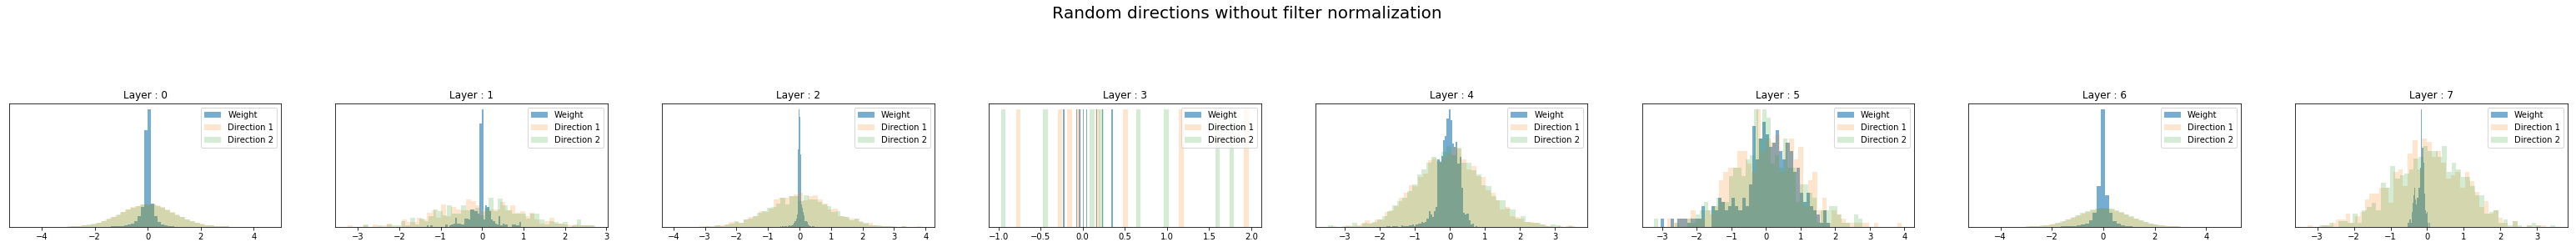

In [42]:
#display without normalization
dir1=[torch.randn(w.size()) for w in copy_of_the_weights]
dir2=[torch.randn(w.size()) for w in copy_of_the_weights]

viz_histogram_weights(copy_of_the_weights,dir1,dir2,"Random directions without filter normalization")

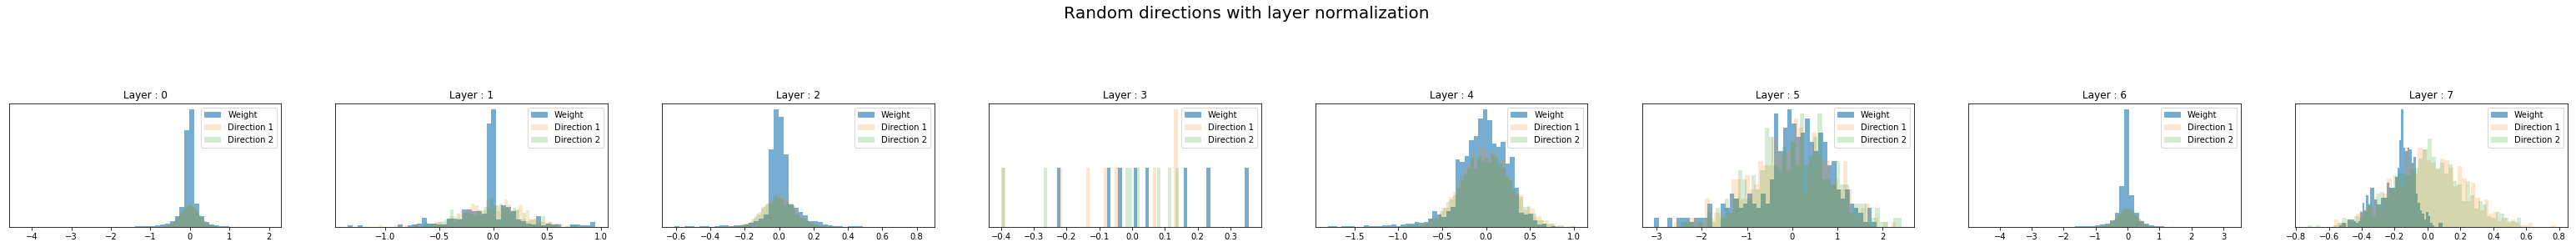

In [43]:
direction1=get_random_weights(copy_of_the_weights)
direction2=get_random_weights(copy_of_the_weights)

viz_histogram_weights(copy_of_the_weights,direction1,direction2,"Random directions with layer normalization")

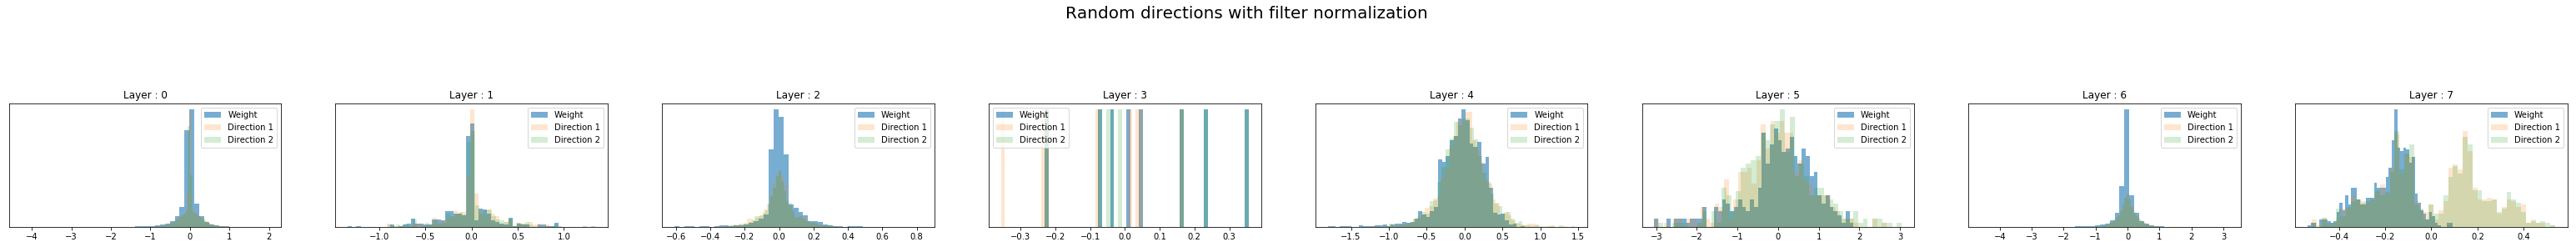

In [44]:
direction1=get_random_weights_filter_norm(copy_of_the_weights)
direction2=get_random_weights_filter_norm(copy_of_the_weights)

viz_histogram_weights(copy_of_the_weights,direction1,direction2,"Random directions with filter normalization")

In [45]:
# create the coordinates 
number_of_points = 9 
small_range = -1.0
large_range =  1.0

xcoordinates = np.linspace(small_range, large_range, num=number_of_points) 
ycoordinates = np.linspace(small_range, large_range, num=number_of_points) 

xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
total_cordinates = np.array(range(number_of_points**2))
alpha   = xcoord_mesh.ravel()[total_cordinates]
beta   = ycoord_mesh.ravel()[total_cordinates]
coordinate = np.c_[alpha,beta]
print('From ',small_range,' to ',large_range,' with ',number_of_points,' total number of coordinate: ', number_of_points**2)

From  -1.0  to  1.0  with  9  total number of coordinate:  81


In [46]:
def create_viz(loss_list,title="none"):
    
    fig = go.Figure(data =
        go.Contour(z=loss_list,x=xcoordinates,y=ycoordinates))
    
    fig.update_layout(height=400, width=500, title_text="Subplots")
    fig.show()
    
    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=loss_list,colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Loss',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); 
    
    fig.update_layout(height=400, width=600, title_text="Subplots")
    iplot(fig); 
    plt.show()
    
 

In [47]:
dataset_eval = dsets.MNIST(root='../data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)



In [48]:
targetByDigits=[]
dataByDigits=[]

for i in range(10):
    dataset_eval = dsets.MNIST(root='../data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
    
    labelIndex= dataset_eval.train_labels==i #get the index of digit i
    targetByDigits.append(dataset_eval.train_labels[labelIndex]) 
    dataByDigits.append(dataset_eval.train_data[labelIndex]) 

/home/anuj/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning:

train_labels has been renamed targets

/home/anuj/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

train_data has been renamed data



## Loss landscape from latent representation of autoencoder

For each digit in mnist dataset, there around 6-7 thousand dataset. We get same number of latent representation. To create a loss landscape, we can compute the mean value of all components in latent representation.
    
In our experiment, we took the mean of latent representation column wise for all datapoints of each digits. As an output we get 8 components in latent representation. We use each component to create a loss landscape.
The same process is done for all 9x9=81 grid points. Hence we get 8 loss landscape.

<img src="../loss_landscape_from_latentRepr.png" height="400" width="600"/>

Selected images of only one label.
E.g. we have 7000 images of ones, then we have (7000x8) latent representation.
take each component for plotting the loss landscapes
    
  

In [49]:
#
#returns 
# 0:latentComponentsMean: mean of mean values taken columnwise, returns single value for each gridpoints
# 1:latentComponents: mean taken columnwise, return 8 values for each gridpoints
# 2:latentComponentsMeanL2: mean of L2 norm taken columnwise, returns single value for each gridpoints
# 3:latentComponentsL2: L2 norm taken columnwise, return 8 values for each gridpoints

def evalRandDirection(RD1,RD2):
    
    #for mean of 8 latent representation components
    latentComponentsMean=np.zeros((number_of_points,number_of_points))
    
    # for each latent representation components
    latentComponents={}
    for m in range(latent_size):
        latentComponents[m]=np.zeros((number_of_points,number_of_points))
    
    #for mean of 8 latent representation components
    latentComponentsMeanL2=np.zeros((number_of_points,number_of_points))
    
    #L2for each latent representation components
    latentComponentsL2={}
    for n in range(latent_size):
        latentComponentsL2[n]=np.zeros((number_of_points,number_of_points)) 
   
    col_value = 0
    for index,_ in enumerate(total_cordinates):
        alphaBeta=coordinate[index]
        weightedRandomDirection= [d0*alphaBeta[0] + d1*alphaBeta[1] for (d0, d1) in zip(RD1,RD2)]
        for (p, w, d) in zip(ae.parameters(), copy_of_the_weights, weightedRandomDirection):
            p.data = w + d.cuda()
        
        with torch.no_grad():
            for i, (images,labels) in enumerate(eval_data_loader):
                #images = to_var(images)
                images = to_var(images.view(images.size(0), -1))
                latentspace,_ = ae(images) #Forward propagation
                
                meanByLatentSize=latentspace.mean(axis=0)               
                for j in range(latent_size):
                    latentComponents[j][col_value,index%number_of_points]=meanByLatentSize[j]

                latentComponentsMean[col_value,index%number_of_points]=meanByLatentSize.mean()
                
                L2norm=torch.norm(latentspace, dim=0)
                for k in range(latent_size):
                    latentComponentsL2[k][col_value,index%number_of_points]=L2norm[k]

                latentComponentsMeanL2[col_value,index%number_of_points]=L2norm.mean()
                   
                temp=index+1
                if temp%number_of_points==0:
                    col_value=col_value+1
                break
    
    return latentComponentsMean,latentComponents,latentComponentsMeanL2,latentComponentsL2
    
        

In [10]:
#plots are saved in HTML format. You can hover over plots and get the coordinates,latent components value
#https://plotly.com/python/interactive-html-export/
    
# orca can be used to save the plots in png or jpg format. 
#https://plotly.com/python/static-image-export/ 



def plotLatentLandscape(location,digits,data):
    fig = make_subplots(rows=2, cols=4)
    for i in range(8):    
        fig.add_trace(
            go.Contour(z=data[i],x=xcoordinates,y=ycoordinates),
            row=i//4+1, col=i%4+1
        )
    fig.update_layout(height=550, width=1000, title_text="Latent Landscape for digit "+str(digits))
    path=location+"/digit_"+str(digits)+".html"
    fig.write_html(path)
    fig.show()
    print("Plot saved to: ", path)
    

def plotlatentLandscapeMean(location,digits,data):
    fig = go.Figure(data =
    go.Contour(z=data,x=xcoordinates,y=ycoordinates))
    fig.update_layout(height=400, width=500, title_text="Latent Landscape for digit "+str(digits))
    path=location+"/digit_"+str(digits)+".html"
    fig.write_html(path)
    
    fig.show()


In [ ]:
torch.manual_seed(0)
direction1=get_random_weights_filter_norm(copy_of_the_weights)
direction2=get_random_weights_filter_norm(copy_of_the_weights)
plotsByDigits=[]

for i in range(10):
    print("computing latent landscape for digit: ",i)
    dataset_eval.targets = targetByDigits[i]
    dataset_eval.data = dataByDigits[i]
    eval_data_loader = torch.utils.data.DataLoader(dataset=dataset_eval,batch_size=60000,shuffle=True)
    plotsByDigits.append(evalRandDirection(direction1,direction2))
    print("Done")

with open('plotsByDigits.pkl', 'wb') as f:
    pickle.dump(plotsByDigits, f)

In [11]:
with open('plotsByDigits.pkl', 'rb') as f:
    plotsByDigits = pickle.load(f)

In [ ]:
plotLocation="latentLanscapes_seed0"
if not os.path.exists(plotLocation):
    os.mkdir(plotLocation)
for i in range(10):
    plotLatentLandscape(plotLocation,i,plotsByDigits[i][1])

In [ ]:
#plotLocation="latentLanscapesMean_seed0"
#if not os.path.exists(plotLocation):
#    os.mkdir(plotLocation)
#for i in range(10):
#    plotlatentLandscapeMean(plotLocation,i,plotsByDigits[i][0])

In [ ]:
torch.manual_seed(1)
direction1_seed1=get_random_weights_filter_norm(copy_of_the_weights)
direction2_seed1=get_random_weights_filter_norm(copy_of_the_weights)
plotsByDigits_seed1=[]

for i in range(10):
    print("computing latent landscape for digit: ",i)
    dataset_eval.targets = targetByDigits[i]
    dataset_eval.data = dataByDigits[i]
    eval_data_loader = torch.utils.data.DataLoader(dataset=dataset_eval,batch_size=60000,shuffle=True)
    plotsByDigits_seed1.append(evalRandDirection(direction1_seed1,direction2_seed1))
    print("Done")

with open('plotsByDigits_seed1.pkl', 'wb') as f:
    pickle.dump(plotsByDigits_seed1, f)   

In [ ]:
plotLocation="latentLanscapes_seed1"
if not os.path.exists(plotLocation):
    os.mkdir(plotLocation)
    
for i in range(10):
    plotLatentLandscape(plotLocation,i,plotsByDigits_seed1[i][1])

    

In [ ]:
torch.manual_seed(0)
d1=get_random_weights(copy_of_the_weights)
d2=get_random_weights(copy_of_the_weights)
plotsByDigitsLayerNorm=[]

for i in range(10):
    print("computing latent landscape for digit: ",i)
    dataset_eval.targets = targetByDigits[i]
    dataset_eval.data = dataByDigits[i]
    eval_data_loader = torch.utils.data.DataLoader(dataset=dataset_eval,batch_size=60000,shuffle=True)
    plotsByDigitsLayerNorm.append(evalRandDirection(d1,d2))
    print("Done")

In [ ]:
plotLocation="latentLandscapes_layerNorm_seed1"
if not os.path.exists(plotLocation):
    os.mkdir(plotLocation)
    
for i in range(10):
    plotLatentLandscape(plotLocation,i,plotsByDigitsLayerNorm[i][1])